In this notebook, we want to study the correlation between train delays and the weather for local trains in Heidelberg.

We use train delay data from all trains and busses that used the station "Heidelberg Hbf Süd" between 1.1.2022 and 1.2.2022. We use weather data from the Deutsche Wetterdienst that was collected between 1.1.2022 and 1.2.2022. Our used latitude and longitute are lat = 49.24 and lon = 8.41.

In [1]:
#import of the relevant modules 
import pandas as pd
import numpy as np
import psycopg2.extras as extras
from datetime import datetime, timedelta
import psycopg2
import pandas.io.sql as sqlio
from database_mapper.config import config
import matplotlib.pyplot as plt
from scipy import stats
import july
from july.utils import date_range

PARAMS = config()

conn = psycopg2.connect(**PARAMS)
conn.autocommit = True
cursor = conn.cursor()

#load train and weather data into pandas dataframes
train_df = sqlio.read_sql_query("SELECT * FROM traindelays3 ORDER BY planned_departure", conn)
weather_df = sqlio.read_sql_query("SELECT * FROM weather_details4", conn)

In [2]:
#add columns with delay in seconds ('delay' has intervals)
train_df['delay_in_seconds'] = train_df['delay'] / np.timedelta64(1, 's')
#convert planned_departure to datetime and add columns with day and hour and month of the data
train_df['planned_departure'] = pd.to_datetime(train_df['planned_departure'])
train_df['planned_departure_day'] = train_df['planned_departure'].dt.day
train_df['planned_departure_hour'] = train_df['planned_departure'].dt.hour
train_df['planned_departure_month'] = train_df['planned_departure'].dt.month
#filter dataset because we only want to study data from January 2022
train_df = train_df[train_df['planned_departure_month'] == 1]



First, the traindelay dataset is analyzed. 

c:\Users\becci\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


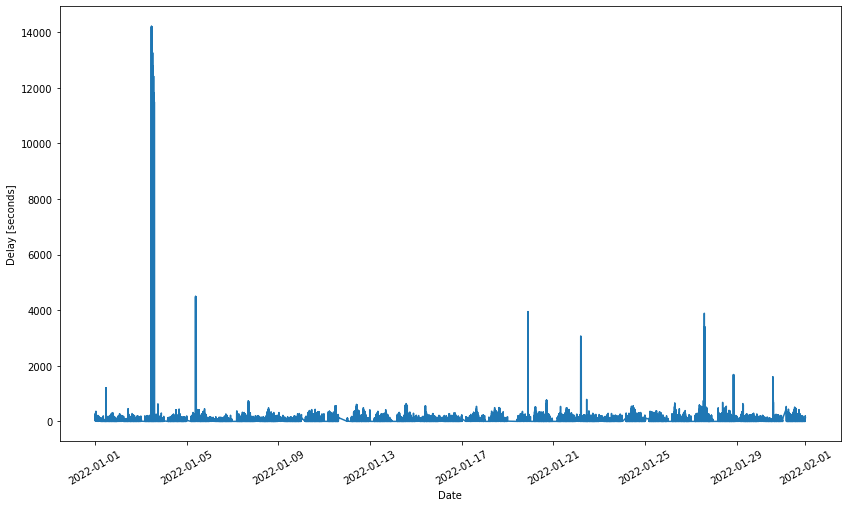

In [4]:
plt.figure(figsize = (14,8))

plt.plot(train_df['planned_departure'],train_df['delay_in_seconds'] , label='delay' )
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Delay [seconds]')

pass

As one can see, there is a huge delay in the beginning of January 2022. However, we want to get a better understanding of the "normal" data, so we set a limit on the y axis for the following plot.

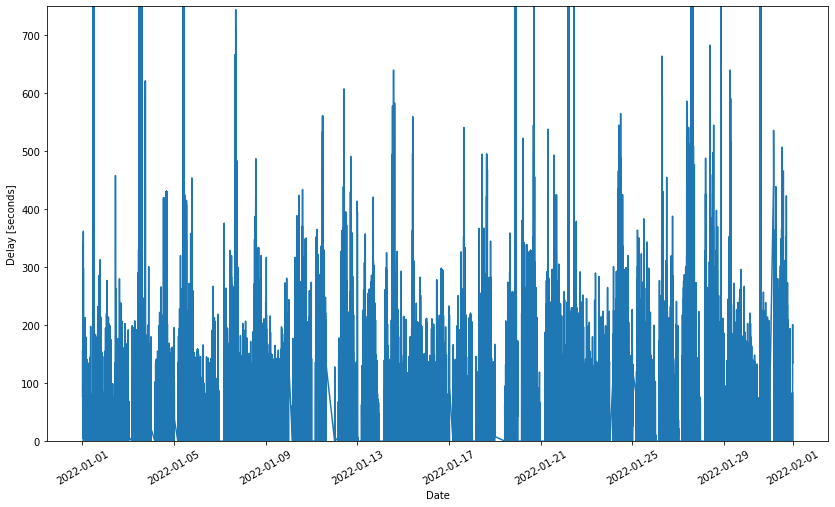

In [5]:
plt.figure(figsize = (14,8))

plt.plot(train_df['planned_departure'],train_df['delay_in_seconds'] , label='delay' )
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Delay [seconds]')

plt.ylim(0, 750)
pass

This gives a clearer picture of the traindelays. For more statistical information on our dataset, we use the scipy.stats function describe:

In [32]:

stats.describe(train_df['delay_in_seconds'])

DescribeResult(nobs=128217, minmax=(0.0, 14216.0), mean=55.56615737382718, variance=132050.45508415543, skewness=32.16165070534379, kurtosis=1118.9667172997592)

This tells us that we have 128217 datapoints and the minimal delay is 0 seconds and the maximum delay is 14216 seconds (ca 3.95h). The mean delay is 55.56 seconds.

Let's make a heatmap that shows the traindelays for every day in January.

c:\Users\becci\AppData\Local\Continuum\anaconda3\lib\site-packages\july\rcmod.py:38: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  rcmod = ConfigDict(mpl.rcParams)


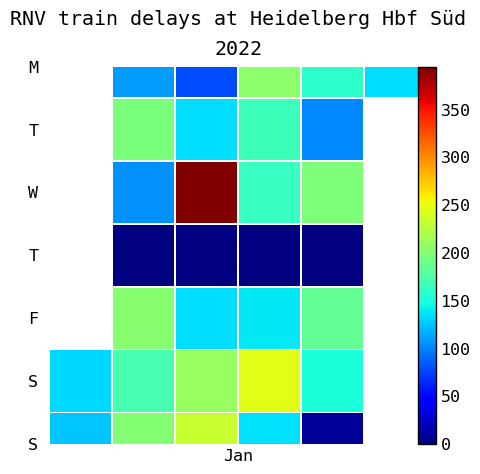

In [6]:


july.heatmap(
    train_df.planned_departure, 
    train_df.delay_in_seconds, 
    cmap="jet", 
    colorbar=True, 
    title="RNV train delays at Heidelberg Hbf Süd"
)
pass


Now we want to get some more information on our dataset

In [11]:
print("90th percentile at:",np.percentile(train_df['delay_in_seconds'], 90), "seconds")
print("portion of zero seconds delays within all delays:", len(train_df[train_df['delay_in_seconds'] == 0])/len(train_df))
train_df_no_zero_delay = train_df[train_df.delay_in_seconds != 0]
print("90th percentile if zero seconds delays are ignored:",np.percentile(train_df_no_zero_delay['delay_in_seconds'], 90), "seconds")
print("99th percentile if zero seconds delays are ignored:",np.percentile(train_df_no_zero_delay['delay_in_seconds'], 99), "seconds")



90th percentile at: 133.0 seconds
portion of zero seconds delays within all delays: 0.5380643752388529
90th percentile if zero seconds delays are ignored: 187.0 seconds
99th percentile if zero seconds delays are ignored: 432.0 seconds


As one can see a big portion of delays are zero seconds. This is unrealistic. We assume that not all trains or busses save data about their realtime departure so that their realtime departure is set equal to their planned departure eventhough this is not the case in reality. Therefore we ignore all data that has zero seconds as delay.

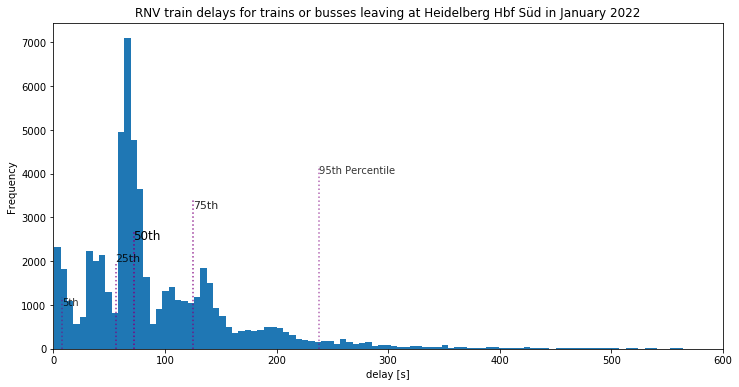

In [13]:
fig, ax = plt.subplots(figsize = (12,6))
df = pd.Series(train_df_no_zero_delay['delay_in_seconds'])

df.plot(kind = "hist", density = False, bins = 2500) 

ax.set_xlabel("delay [s]")


ax.set_xlim(0, 600)

ax.set_title("RNV train delays for trains or busses leaving at Heidelberg Hbf Süd in January 2022")
quant_5, quant_25, quant_50, quant_75, quant_95 = df.quantile(0.05), df.quantile(0.25), df.quantile(0.5), df.quantile(0.75), df.quantile(0.95)

quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color='purple')

ax.text(quant_5-.1, 1000, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 2000, "25th", size = 11, alpha = 0.85)
ax.text(quant_50-.13, 2500, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 3200, "75th", size = 11, alpha = 0.85)
ax.text(quant_95-.25, 4000, "95th Percentile", size = 10, alpha =.8)

plt.show()

Now the weather dataset is analyzed

In [3]:
weather_df['timestamp_month'] = weather_df['timestamp'].dt.month
#we only want data from january
weather_df = weather_df[weather_df['timestamp_month'] == 1]


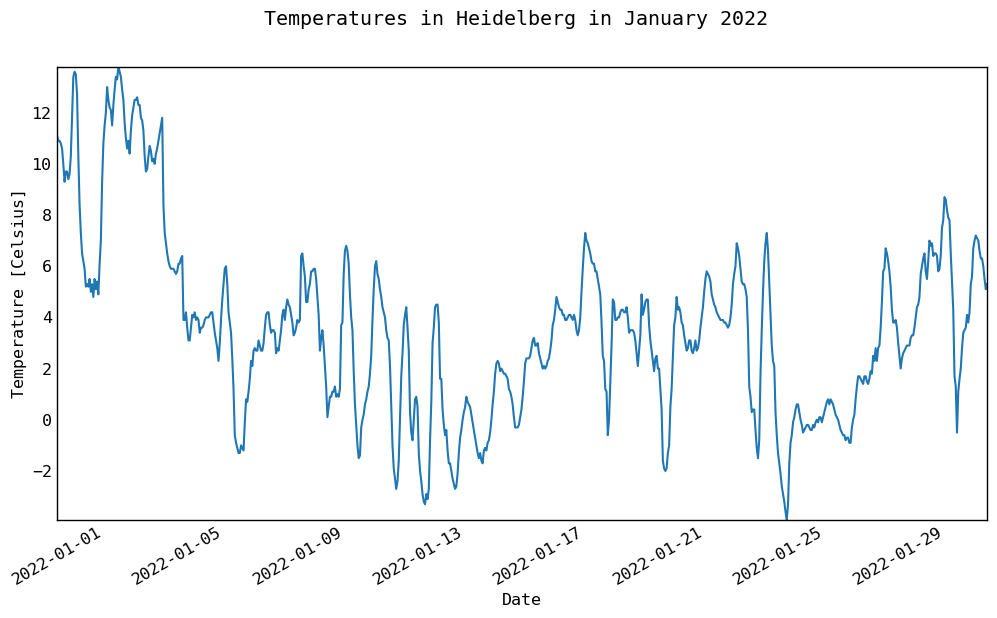

In [23]:
plt.figure(figsize = (12,6))
plt.plot(weather_df['timestamp'],weather_df['temperature'] , label='temperature' )
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Temperature [Celsius]')
plt.title('Temperatures in Heidelberg in January 2022 ')
pass

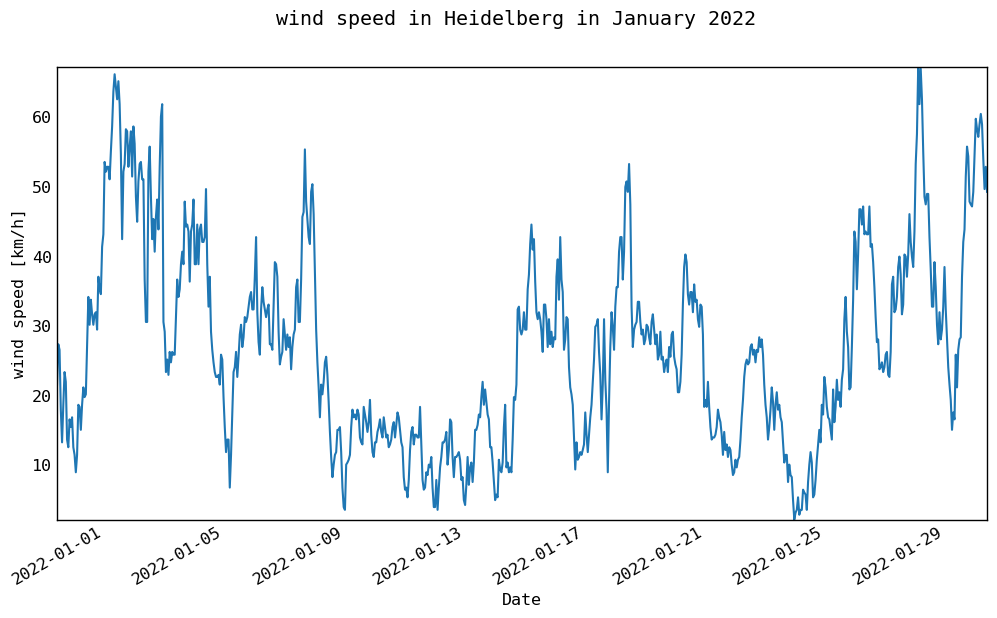

In [24]:
plt.figure(figsize = (12,6))
plt.plot(weather_df['timestamp'],weather_df['wind_speed'] , label='temperature' )
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('wind speed [km/h]')
plt.title('wind speed in Heidelberg in January 2022 ')
pass

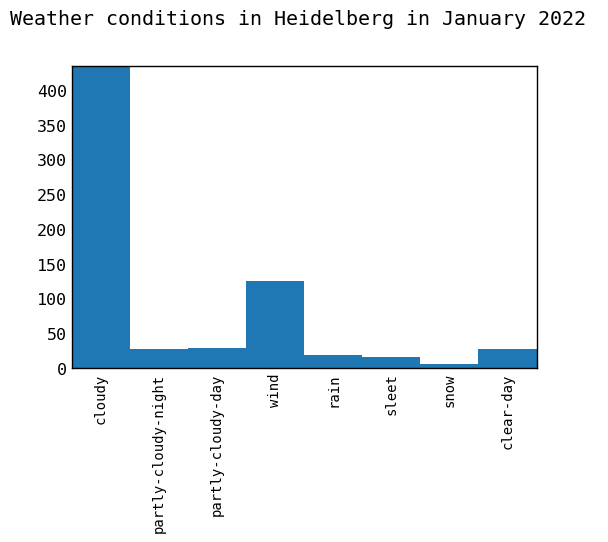

In [25]:
plt.hist(weather_df['icon'], bins=np.arange(9)-0.5)
plt.xticks(rotation=90, fontsize=10)
plt.title('Weather conditions in Heidelberg in January 2022 ')
pass

Now the train and weather data gets merged into one dataframe and correlations are studied.

In [4]:

weather_df['timestamp_hour'] = weather_df['timestamp'].dt.hour
weather_df['timestamp_day'] = weather_df['timestamp'].dt.day

blub = train_df.groupby(['planned_departure_day', 'planned_departure_hour'] , as_index=False)['delay_in_seconds'].sum()

merged_df = blub.merge(weather_df, left_on=[ 'planned_departure_day', 'planned_departure_hour'], right_on=[ 'timestamp_day', 'timestamp_hour'])


In [8]:

print( "correlation between delay and temperature:", merged_df['delay_in_seconds'].corr(merged_df['temperature']))
print("correlation between delay and wind speed:",merged_df['delay_in_seconds'].corr(merged_df['wind_speed']))
print("correlation between delay and pressure:",merged_df['delay_in_seconds'].corr(merged_df['pressure_msl']))
print("correlation between delay and wind direction:",merged_df['delay_in_seconds'].corr(merged_df['wind_direction']))
print("correlation between delay and cloudyness:",merged_df['delay_in_seconds'].corr(merged_df['cloud_cover']))
print("correlation between delay and humdidity:",merged_df['delay_in_seconds'].corr(merged_df['relative_humidity']))



correlation between delay and temperature: 0.12108847514269996
correlation between delay and wind speed: 0.13164864848247954
correlation between delay and pressure: -0.04068544325606333
correlation between delay and wind direction: 0.030305726366271525
correlation between delay and cloudyness: 0.022222451617304528
correlation between delay and humdidity: -0.11276354922226904


-> Weather and train delays are not correlated